<a href="https://colab.research.google.com/github/ehsankarami1358/LOKA_HYDRO/blob/main/H%C4%B0LLCHART_COMP_ACTUAL_LOKA_U2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
import os

# ---------------------------
# INPUT FILES (your uploads)
# ---------------------------
hill_path = r"/content/loka_hillchart_filled_all_points.xlsx"
op_path   = r"/content/u2_MW_OP_FL_L_1_1_2026_11_2_2026_R3.csv"
out_dir   = r"/content/data"

# Create the output directory if it doesn't exist
os.makedirs(out_dir, exist_ok=True)

# ---------------------------
# 1) LOAD + PARSE HILL CHART
# ---------------------------
hill_raw = pd.read_excel(hill_path, sheet_name="Sheet1")

def parse_hill_blocks(df):
    blocks = []
    i = 0
    while i < len(df):
        v = df.iloc[i, 0]
        if isinstance(v, str) and v.strip().startswith("NetHead_m="):
            head = float(v.split("=")[1])

            # find next row with "ActivePower_MW"
            j = i + 1
            while j < min(i + 8, len(df)) and not (
                isinstance(df.iloc[j, 0], str) and df.iloc[j, 0].strip() == "ActivePower_MW"
            ):
                j += 1
            if j >= len(df):
                i += 1
                continue

            power = pd.to_numeric(df.iloc[j,   1:], errors="coerce").values
            flow  = pd.to_numeric(df.iloc[j+1, 1:], errors="coerce").values
            eta   = pd.to_numeric(df.iloc[j+2, 1:], errors="coerce").values
            opn   = pd.to_numeric(df.iloc[j+3, 1:], errors="coerce").values

            block = pd.DataFrame({
                "Head_m": head,
                "Power_MW": power,
                "Flow_m3s": flow,
                "Eta_hill": eta,
                "Opening_hill_pct": opn
            }).dropna(subset=["Power_MW", "Flow_m3s", "Eta_hill"])

            blocks.append(block)
            i = j + 4
        else:
            i += 1

    if blocks:
        return pd.concat(blocks, ignore_index=True)
    return pd.DataFrame(columns=["Head_m","Power_MW","Flow_m3s","Eta_hill","Opening_hill_pct"])

hill_table = parse_hill_blocks(hill_raw)

# Interpolators: Flow(H,P) and Eta(H,P)
X = hill_table[["Head_m","Power_MW"]].values
flow_interp = LinearNDInterpolator(X, hill_table["Flow_m3s"].values)
eta_interp  = LinearNDInterpolator(X, hill_table["Eta_hill"].values)

# ---------------------------
# 2) LOAD OPERATING CSV
# ---------------------------
op = pd.read_csv(op_path)
op["Timestamp"] = pd.to_datetime(op["Timestamp"], errors="coerce")

op["NetHead_m"] = op["HEAD_L(m)"] - op["TAIL_L(m)"]
op["Power_MW"]  = op["ACTIVE_POWER(MW)"]
op["Flow_m3s"]  = op["FLOW(m3/s)"]
op["Opening_pct"] = op["OPPENING(%)"]
op["Speed_rpm"] = op["SPEED(RPM)"]

op = op.dropna(subset=["Timestamp","NetHead_m","Power_MW","Flow_m3s","Speed_rpm"])

# Nominal speed from running points
run_mask = (op["Power_MW"] > 20) & (op["Flow_m3s"] > 5)
nom_speed = op.loc[run_mask, "Speed_rpm"].median()

# Stable filter (tune if needed)
stable_mask = (
    (op["Power_MW"] > 20) &
    (op["Flow_m3s"] > 5) &
    (op["Opening_pct"] > 1) &
    (op["Speed_rpm"].between(nom_speed - 0.5, nom_speed + 0.5))
)
op_stable = op.loc[stable_mask].copy()

# ---------------------------
# 3) ACTUAL EFFICIENCY
# ---------------------------
rho = 1000.0
g = 9.80665
op_stable["Eta_actual"] = (op_stable["Power_MW"]*1e6) / (rho*g*op_stable["Flow_m3s"]*op_stable["NetHead_m"])

# ---------------------------
# 4) EXPECTED FROM HILL CHART
# ---------------------------
op_stable["Flow_expected"] = flow_interp(op_stable["NetHead_m"].values, op_stable["Power_MW"].values)
op_stable["Eta_expected"]  = eta_interp(op_stable["NetHead_m"].values, op_stable["Power_MW"].values)

# Keep only points inside hill chart domain
op_cmp = op_stable.dropna(subset=["Flow_expected","Eta_expected"]).copy()

op_cmp["Flow_error_m3s"] = op_cmp["Flow_m3s"] - op_cmp["Flow_expected"]
op_cmp["Flow_error_pct"] = 100.0 * op_cmp["Flow_error_m3s"] / op_cmp["Flow_expected"]

op_cmp["Eta_error"]      = op_cmp["Eta_actual"] - op_cmp["Eta_expected"]
op_cmp["Eta_error_pct"]  = 100.0 * op_cmp["Eta_error"] / op_cmp["Eta_expected"]

# ---------------------------
# 5) QUICK SUMMARY
# ---------------------------
print("Stable points:", len(op_cmp))
print("Net head range (m):", op_cmp["NetHead_m"].min(), "to", op_cmp["NetHead_m"].max())
print("Power range (MW):", op_cmp["Power_MW"].min(), "to", op_cmp["Power_MW"].max())

Stable points: 282
Net head range (m): 76.48018999999988 to 86.65418999999997
Power range (MW): 81.48558 to 141.5192


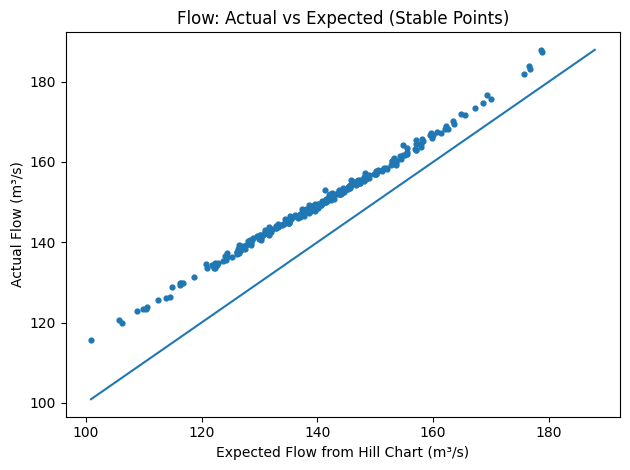

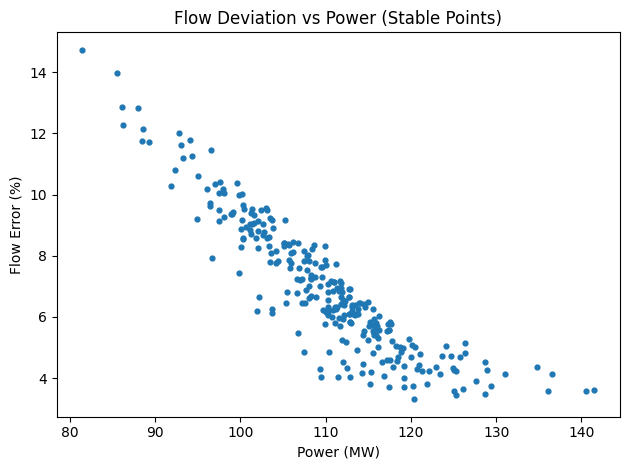

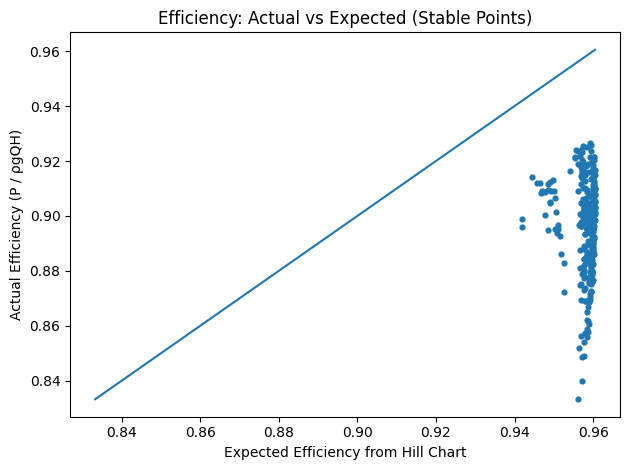

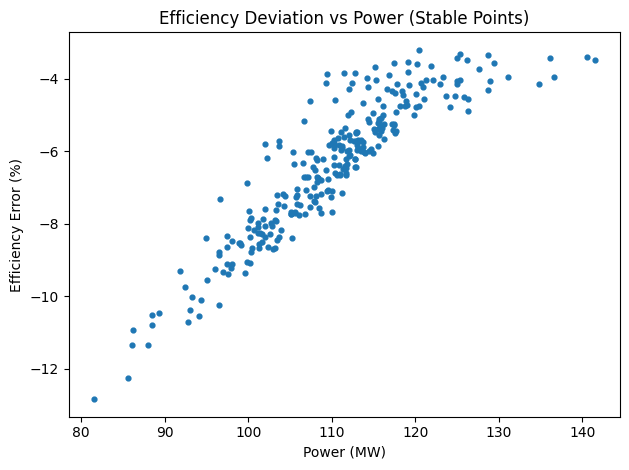

In [9]:
# ---------------------------
# 6) PLOTS (no seaborn)
# ---------------------------
# Actual vs Expected Flow
plt.figure()
plt.scatter(op_cmp["Flow_expected"], op_cmp["Flow_m3s"], s=12)
mn = min(op_cmp["Flow_expected"].min(), op_cmp["Flow_m3s"].min())
mx = max(op_cmp["Flow_expected"].max(), op_cmp["Flow_m3s"].max())
plt.plot([mn,mx],[mn,mx])
plt.xlabel("Expected Flow from Hill Chart (m³/s)")
plt.ylabel("Actual Flow (m³/s)")
plt.title("Flow: Actual vs Expected (Stable Points)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "flow_actual_vs_expected.png"), dpi=200)
plt.show()

# Flow error vs Power
plt.figure()
plt.scatter(op_cmp["Power_MW"], op_cmp["Flow_error_pct"], s=12)
plt.xlabel("Power (MW)")
plt.ylabel("Flow Error (%)")
plt.title("Flow Deviation vs Power (Stable Points)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "flow_error_pct_vs_power.png"), dpi=200)
plt.show()

# Efficiency actual vs expected
plt.figure()
plt.scatter(op_cmp["Eta_expected"], op_cmp["Eta_actual"], s=12)
mn = min(op_cmp["Eta_expected"].min(), op_cmp["Eta_actual"].min())
mx = max(op_cmp["Eta_expected"].max(), op_cmp["Eta_actual"].max())
plt.plot([mn,mx],[mn,mx])
plt.xlabel("Expected Efficiency from Hill Chart")
plt.ylabel("Actual Efficiency (P / ρgQH)")
plt.title("Efficiency: Actual vs Expected (Stable Points)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "eta_actual_vs_expected.png"), dpi=200)
plt.show()

# Efficiency error vs Power
plt.figure()
plt.scatter(op_cmp["Power_MW"], op_cmp["Eta_error_pct"], s=12)
plt.xlabel("Power (MW)")
plt.ylabel("Efficiency Error (%)")
plt.title("Efficiency Deviation vs Power (Stable Points)")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "eta_error_pct_vs_power.png"), dpi=200)
plt.show()

# ---------------------------


In [8]:
# 7) EXPORT REPORT TO EXCEL
# ---------------------------
summary = pd.DataFrame([{
    "n_stable_points": len(op_cmp),
    "net_head_min_m": float(op_cmp["NetHead_m"].min()),
    "net_head_max_m": float(op_cmp["NetHead_m"].max()),
    "power_min_MW": float(op_cmp["Power_MW"].min()),
    "power_max_MW": float(op_cmp["Power_MW"].max()),
    "flow_error_mean_pct": float(op_cmp["Flow_error_pct"].mean()),
    "flow_error_median_pct": float(op_cmp["Flow_error_pct"].median()),
    "eta_error_mean_pct": float(op_cmp["Eta_error_pct"].mean()),
    "eta_error_median_pct": float(op_cmp["Eta_error_pct"].median()),
}])

report_path = os.path.join(out_dir, "unit2_vs_hillchart_report.xlsx")
with pd.ExcelWriter(report_path, engine="openpyxl") as w:
    summary.to_excel(w, index=False, sheet_name="Summary")
    hill_table.to_excel(w, index=False, sheet_name="Hill_flat_table")
    op_cmp.to_excel(w, index=False, sheet_name="Stable_points_with_compare")

print("Saved:", report_path)

Saved: /content/data/unit2_vs_hillchart_report.xlsx
